In [305]:
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [306]:
class Regression:
    
    def __init__(self, feat_dims=0):
        # alpha is weight decay hyperparameter
        
        self.learning_rate = 0.00000001
        self.epochs = 10
        self.batch_size = 8
        
        self.feat_dims = feat_dims
        self.output_classes = 1
        
        # create weights array/matrix size (num features x output)
        self.weights = 0.0001 * np.random.rand(self.feat_dims, self.output_classes)
        self.alpha = 0.01  # regularization strength
        
        self.y_mean = None
        
    def normalize_feat(self, x, mean=None, std=None):
        # normalize the feature data.  test data must pass mean and std
        
        if mean is None:
            mean = np.mean(x, axis=0)
            
        if std is None:
            std = np.std(x, axis=0)
        
        # sub the mean per column
        x -= mean

        # div by the standard dev.
        x /= std

        return x, mean, std
        
    def load_data(self, fname, bias=1):
        
        data = loadtxt(fname, delimiter=',')
        
        # loads data, normalizes, and appends a bias vector to the data

        TRAIN_NUM = 463714  # training data up to this point

        # process training data
        x_train = data[:TRAIN_NUM,1:].astype(float)  # parse train
        x_train, train_mean, train_std = self.normalize_feat(x_train)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_train.shape[0], bias))

        # append bias with hstack
        x_train = np.hstack((x_train, col_bias))
        
        # convert label vals to int and to vector
        y_train = data[:TRAIN_NUM,0].astype(int)
        y_train = y_train.reshape((-1, 1))

        # -------------------
        
        # process test data
        x_test = data[TRAIN_NUM:,1:].astype(float)  # parse test
        x_test, _, _ = self.normalize_feat(x_test, train_mean, train_std)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_test.shape[0], bias))

        # append bias with hstack
        x_test = np.hstack((x_test, col_bias))    

        # convert label vals to int and to vector
        y_test = data[TRAIN_NUM:,0].astype(int)
        y_test = y_test.reshape((-1, 1))  # convert to column vector

        return x_train, y_train, x_test, y_test

    def musicMSE(self, pred, gt):

        # make sure to floor by converting to int()
        diff = pred - gt
        mse = (np.square(diff)).mean()

        return mse
    
    def label_sub_mean(self, label):
        
        # find the mean
        self.y_mean = np.mean(label)
        
        # sub mean
        temp = label - self.y_mean
        
        return temp

    def train_loss(self, x, yt_sm):
        # calc the cost
        # yt = true label, sub mean label
        
        n_samples = x.shape[0]        
        pred_y = np.dot(x, self.weights)
        residual = np.square(pred_y - yt_sm) 
        sq_residual = np.linalg.norm(residual)
        
        loss = sq_residual + self.alpha + np.square( np.linalg.norm(self.weights) )
    
        return loss / n_samples
    
    def test_loss(self, x, yt_sm):
        # calc the cost at test time
        # yt = true label, is regular label
        
        n_samples = x.shape[0]  
        
        # need to add the mean back to label
        yt = yt_sm + self.y_mean
        
        # predict
        pred_y = np.dot(x, self.weights)
        
        # need to add the y mean back
        pred_y = pred_y + self.y_mean
        
        residual = np.square(pred_y - yt) 
        sq_residual = np.linalg.norm(residual)
        
        loss = sq_residual + self.alpha + np.square( np.linalg.norm(self.weights) )
    
        return loss / n_samples
    
    def gradient(self, x, yt_sm):
        
        n_samples = x.shape[0]
        
        pred_y = np.dot(x, self.weights)
        residual = np.square(pred_y - yt_sm) 
        dW = np.dot(x.T, residual) + 2 * self.weights * self.alpha
        
        return dW / n_samples

    def calc_accuracy(self, x, y_sm):
        
        # predict
        pred_y = np.dot(x, self.weights)
        
        # add the y mean to the pred
        pred_y += self.y_mean
        
        # add the y mean back to the labels
        y_labels = y_sm + self.y_mean
        
        # calc the MSE
        mse = self.musicMSE(pred_y, y_labels)
        
        print('MSE: ', mse)
        
        return mse, pred_y

    def train_phase(self, x_train, y_train_sm):
        # shuffle data together, and forward prop by batch size, and add momentum

        num_train = x_train.shape[0]
        losses = []
        # Randomize the data (using sklearn shuffle)
        x_train, y_train_sm = shuffle(x_train, y_train_sm)

        # get the next batch (loop through number of training samples, step by batch size)
        for i in range(0, num_train, self.batch_size):

            # grab the next batch size
            x_train_batch = x_train[i:i + self.batch_size]
            y_train_batch_sm = y_train_sm[i:i + self.batch_size]

            # calc loss
            loss = self.train_loss(x_train_batch, y_train_batch_sm)
            
            # calc gradient (dont forget the regularization !)
            
            # ----------- need to add regularization!!! -------------
            dW = self.gradient(x_train_batch, y_train_batch_sm)
            
            self.weights -= dW * self.learning_rate  # update the weights
            losses.append(loss)  # save the losses

        return np.average(losses)  # return the average

    def test_phase(self, x, y_sm):
        # extra, but more explicit calc of loss and gradient during testing (no back prop)
        
        # calc loss
        loss = self.test_loss(x, y_sm)
        
        return loss
        
    def run_epochs(self, x_train, y_train_sm, x_test, y_test_sm):
        # start the training/valid by looping through epochs

        # store losses and accuracies here
        train_losses = []
        test_losses = []
        train_acc_arr = []
        test_acc_arr = []

        for e in range(self.epochs): # loop through epochs

            print('Epoch {} / {}...'.format(e + 1, self.epochs))

            # calc loss and accuracies
            train_loss = self.train_phase(x_train, y_train_sm)
            test_loss = self.test_phase(x_test, y_test_sm)
            
            train_acc, train_preds = self.calc_accuracy(x_train, y_train_sm)
            test_acc, test_preds = self.calc_accuracy(x_test, y_test_sm)

            # append vals to lists
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_acc_arr.append(train_acc)
            test_acc_arr.append(test_acc)
        
#         return train_losses, test_losses

        # return all the vals
        return train_losses, test_losses, train_acc_arr, test_acc_arr, test_preds


    def plot_graph(self, train_losses, test_losses, train_acc, test_acc):
        # plot graph
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train loss")
        plt.plot(test_losses, label="Test loss")
        plt.legend(loc='best')
        plt.title("Epochs vs. Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss (Cross entropy)")

        plt.subplot(1, 2, 2)
        plt.plot(train_acc, label="Train Accuracy")
        plt.plot(test_acc, label="Test Accuracy")
        # plt.legend(loc='best')
        plt.title("Epochs vs Accuracy")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

    def make_mesh_grid(self, x, y, h=0.02):
        # make a mesh grid for the decision boundary
        
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
        x_x, y_y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return x_x, y_y  # matrix of x-axis and y-axis

    def plot_contours(self, plt, x_x, y_y, **params):
        # plot contours    

        array = np.array([x_x.ravel(), y_y.ravel()])
        f = np.dot(array.T, self.weights)
        prob = self.softmax(f)
        Q = np.argmax(prob, axis=1) + 1
        Q = Q.reshape(x_x.shape)
        plt.contourf(x_x, y_y, Q, **params)  # takes in variable number of params

    def plot_decision_boundary(self, x, y):
        # plot decision boundary

        markers = ('o', '.', 'x')
        colors = ('yellow', 'grey', 'green')
        cmap = ListedColormap(colors[:len(np.unique(y))])
        x_x, y_y = self.make_mesh_grid(x, y)
        self.plot_contours(plt, x_x, y_y, cmap=plt.cm.coolwarm, alpha=0.8)
        
        # plot training points
        for idx, cl in enumerate(np.unique(y)):
            xBasedOnLabel = x[np.where(y[:,0] == cl)]
            plt.scatter(x=xBasedOnLabel[:, 0], y=xBasedOnLabel[:, 1], c=cmap(idx),
                        cmap=plt.cm.coolwarm, marker=markers[idx], label=cl)
        plt.xlim(x_x.min(), x_x.max())
        plt.ylim(y_y.min(), y_y.max())
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Decision Boundary - Softmax Classifier")
        plt.legend(loc='upper left')
        plt.show()


In [307]:
# create Regression() object to load data
regr = Regression()

In [308]:
# load the data
fname = 'YearPredictionMSD.txt'
x_train, y_train, x_test, y_test = regr.load_data(fname)

In [309]:
# discuss the properties of the data
x_min = np.min(x_train)
x_max = np.max(x_train)

y_min = np.min(y_train)
y_max = np.max(y_train)


# the range of the x feature values is huge, we from -14,000 to 65,000, with a wide
# range in scales too, from 1000s to decimals, so we'll need to normalize

# for the y labels, it's in years, from 1922-2011, and roughly the same in the test,
# though slightly wider range.

# The 90's and 2000's are much more over represented than the rest of the 
# years, expecially the earlier you get.

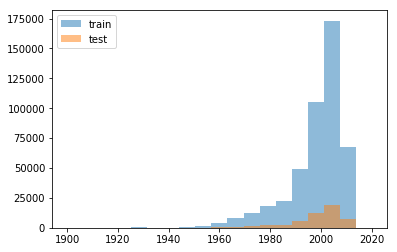

In [310]:
bins = np.linspace(1900, 2020, 20)

plt.hist(y_train, bins, alpha=0.5, label='train')
plt.hist(y_test, bins, alpha=0.5, label='test')
plt.legend(loc='upper left')
plt.show()

In [311]:
#  find the most common year (in test data)

years_arr, count = np.unique(y_test, return_counts=True)
year_count_dict = dict(zip(years_arr, count))
# year_count_dict

In [312]:
# find the loss if every prediction is most commmon 
n_samples = x_train.shape[0]
most_common_year = 2007
common_pred = np.full((n_samples, 1), most_common_year)

In [313]:
most_common_loss = regr.musicMSE(common_pred, y_train)
most_common_loss
#  most common year loss = 193.87

193.87802179791854

In [314]:
# find loss for 1998
n_samples = x_train.shape[0]
most_common_year = 1998
common_pred = np.full((n_samples, 1), most_common_year)


In [315]:
loss_1998 = regr.musicMSE(common_pred, y_train)
loss_1998
#  1998 year loss = 119.82

119.82739576549339

In [316]:
# ==========  Ridge Regression Training  =============

feat_dims = x_train.shape[1]

# create Regression() object to run training
regr = Regression(feat_dims)

# convert labels to floats
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# sub mean from y labels
y_train_sm = regr.label_sub_mean(y_train)
y_test_sm = regr.label_sub_mean(y_test)

# print('y train', y_train)
# print('y sub mean: ', y_train_sm)

# train_losses, test_losses = regr.run_epochs(x_train, y_train_sm, x_test, y_test_sm)

train_losses, test_losses, train_acc_arr, test_acc_arr, test_preds = regr.run_epochs(x_train, y_train_sm, x_test, y_test_sm)



Epoch 1 / 10...
MSE:  118.77863559226525
MSE:  116.90682801747471
Epoch 2 / 10...
MSE:  117.96293924408202
MSE:  116.136086085325
Epoch 3 / 10...
MSE:  117.22710881122968
MSE:  115.44669262787298
Epoch 4 / 10...
MSE:  116.56815180903361
MSE:  114.83591977432657
Epoch 5 / 10...
MSE:  115.98407050153439
MSE:  114.30199721760897
Epoch 6 / 10...
MSE:  115.47349088130345
MSE:  113.84391153310828
Epoch 7 / 10...
MSE:  115.03665584902261
MSE:  113.46223100878356
Epoch 8 / 10...
MSE:  114.67465270373951
MSE:  113.1584102698578
Epoch 9 / 10...
MSE:  114.3898055965568
MSE:  112.93533007507378
Epoch 10 / 10...
MSE:  114.1856685733344
MSE:  112.79688225973828


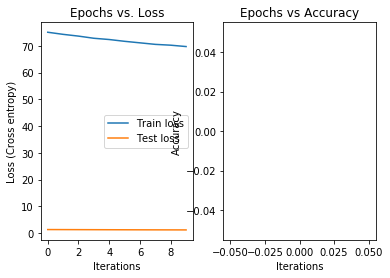

In [317]:
# plot loss and accuracies graphs

# train_acc = []
# test_acc = []

regr.plot_graph(train_losses, test_losses, train_acc, test_acc)

In [318]:
test_losses

[1.311725995512637,
 1.2946487261562212,
 1.2782075886981603,
 1.262359574337036,
 1.2470814265283408,
 1.232339550393648,
 1.218126734110073,
 1.2044433019811367,
 1.1912962010660946,
 1.1787149382061508]

In [319]:
train_losses

[75.08546217460531,
 74.29751428712298,
 73.63882186391798,
 72.83288475986458,
 72.36161902638942,
 71.69412030355785,
 71.12357731874177,
 70.5501582836138,
 70.24410328380456,
 69.73368370314279]

In [320]:
train_acc


[]